<a href="https://colab.research.google.com/github/msohail95/SemanticSegmentation/blob/main/SemanticSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semantic Segmentation

In this notebook we did semantic segmentation on a dataset that contains following class:



*   "Sky"
* "Building"
* "Pole"
* "Road"
* "Pavement"
* "Tree"
* "SignSymbol"
* "Fence"
* "Car"
* "Pedestrian"
* "Bicyclist"

We used two architectures with customized changes to get better accuracy.



1.   In first we created simple U-Net with pretrained VGG16 as backbone and performed transfer learning to achieve results as high as possible. We aquired the maximum accuracy of 87%.
2.   In second approach we modified our architecture to use Dialated Spatial Pyaramid Pooling as done in DeepLabV3+ and we used VGG16 as backbone, but this time we set some of it's layers to be trainable. We aquired the maximum accuracy of over 89%.



### Importing necessary liabraries

In [1]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization, Conv2DTranspose
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from scipy.io import loadmat

### Link to google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Creating paths to all images and annotations

We plit training data and 80-20 ratio for validation. There are 294 training and 73 validation samples in our dataset

In [3]:
DATA_DIR = "/content/drive/MyDrive/A3_Dataset/dataset1/"
IMAGE_SIZE = 512
BATCH_SIZE = 4
NUM_CLASSES = 12
NUM_TRAIN_IMAGES = 294
NUM_VAL_IMAGES = 73

train_images = sorted(glob(os.path.join(DATA_DIR, "images_prepped_train/*")))[:NUM_TRAIN_IMAGES]
train_masks = sorted(glob(os.path.join(DATA_DIR, "annotations_prepped_train/*")))[:NUM_TRAIN_IMAGES]
val_images = sorted(glob(os.path.join(DATA_DIR, "images_prepped_train/*")))[
    NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES
]
val_masks = sorted(glob(os.path.join(DATA_DIR, "annotations_prepped_train/*")))[
    NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES
]

### Loading images and creating datagenerators for training and validation

In [4]:
def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_png(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    else:
        image = tf.image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = image / 127.5 - 1
    return image


def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask


def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset

train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)

print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)

Train Dataset: <BatchDataset element_spec=(TensorSpec(shape=(4, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 512, 512, 1), dtype=tf.float32, name=None))>
Val Dataset: <BatchDataset element_spec=(TensorSpec(shape=(4, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 512, 512, 1), dtype=tf.float32, name=None))>


## First approach

We resized data to 512x512. Then we created our U-Net architecture by using VGG16 as backbone. The bridge was created at 32x32 diamension

### UNet with VGG16

Here is implementation of our first approach. We used moduler approach and create a conv_block and a decoder_block for generalization.

In [73]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def VGG16_Unet(image_size, num_classes):
    """ Input """
    model_input = keras.Input(shape=(image_size, image_size, 3))

    """ Pre-trained VGG16 Model """
    vgg16 = keras.applications.VGG16(include_top=False, weights="imagenet", input_tensor=model_input)

    """ Encoder """
    s1 = vgg16.get_layer("block1_conv2").output         ## (512 x 512)
    s2 = vgg16.get_layer("block2_conv2").output         ## (256 x 256)
    s3 = vgg16.get_layer("block3_conv3").output         ## (128 x 128)
    s4 = vgg16.get_layer("block4_conv3").output         ## (64 x 64)

    """ Bridge """
    b1 = vgg16.get_layer("block5_conv3").output         ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)


    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(d4)
    return keras.Model(inputs=model_input, outputs=model_output)


model = VGG16_Unet(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 512, 512, 64  1792        ['input_14[0][0]']               
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 512, 512, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

### Compilation and Training

We used  

*   SparseCategoricalCrossentropy loss
*   Adam optimizer with learning rate 0.0001
* Accuracy as measure matrix
* 50 epochs for training
* 20% split for validation



In [74]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=loss,
    metrics=["accuracy"],
)

history = model.fit(train_dataset, validation_data=val_dataset, epochs=50)


Epoch 1/50
73/73 [==============================] - 91s 1s/step - loss: 1.5928 - accuracy: 0.5484 - val_loss: 6.3452 - val_accuracy: 0.3104
Epoch 2/50
73/73 [==============================] - 79s 1s/step - loss: 1.1312 - accuracy: 0.6691 - val_loss: 1.7047 - val_accuracy: 0.4979
Epoch 3/50
73/73 [==============================] - 80s 1s/step - loss: 1.0074 - accuracy: 0.6994 - val_loss: 1.1689 - val_accuracy: 0.6933
Epoch 4/50
73/73 [==============================] - 80s 1s/step - loss: 0.9254 - accuracy: 0.7284 - val_loss: 1.3821 - val_accuracy: 0.6673
Epoch 5/50
73/73 [==============================] - 80s 1s/step - loss: 0.8752 - accuracy: 0.7422 - val_loss: 0.9964 - val_accuracy: 0.7272
Epoch 6/50
73/73 [==============================] - 75s 1s/step - loss: 0.8226 - accuracy: 0.7533 - val_loss: 1.0298 - val_accuracy: 0.7249
Epoch 7/50
73/73 [==============================] - 75s 1s/step - loss: 0.7877 - accuracy: 0.7603 - val_loss: 0.9566 - val_accuracy: 0.7370
Epoch 8/50
73/73 [==

### Test Dataset

We used 101 images as test samples. Test data was not used in training.

###Loading and creating test data generator

In [10]:
test_images = sorted(glob(os.path.join(DATA_DIR, "images_prepped_test/*")))[:NUM_TRAIN_IMAGES]
test_masks = sorted(glob(os.path.join(DATA_DIR, "annotations_prepped_test/*")))[:NUM_TRAIN_IMAGES]
test = data_generator(train_images, train_masks)

### Test Accuracy

We aquired maximum test accuracy of 87.61% with 0.37 test loss

In [76]:
preds = model.evaluate(test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

73/73 [==============================] - 34s 459ms/step - loss: 0.3767 - accuracy: 0.8761
Loss = 0.37665411829948425
Test Accuracy = 0.8761255145072937


### Training/Val accuracy/loss graph

Here is our traing and validation accuracy and loss graph

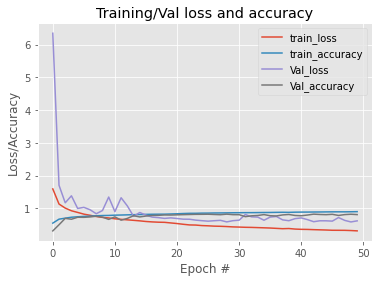

In [77]:
import matplotlib.pyplot as plt
N = np.arange(0, 50)
plt.style.use('ggplot')
plt.figure()
plt.plot(N, history.history['loss'], label='train_loss')
plt.plot(N, history.history['accuracy'], label='train_accuracy')
plt.plot(N, history.history['val_loss'], label='Val_loss')
plt.plot(N, history.history['val_accuracy'], label='Val_accuracy')
plt.title('Training/Val loss and accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

### Qualitative Results

We have shown few test samples to show how our model is perfoming. We created a custome colormap to show each class

In [ ]:
# creating the Colormap
colormap = [[0,255,0],[255,0,0],[0,0,255],[255,255,0],[255,0,255],[0,255,255],[145,0,145],[145,145,0],[0,145,145],[255,145,145],[145,255,145],[145,145,255]]




def infer(model, image_tensor):
    predictions = model.predict(np.expand_dims((image_tensor), axis=0))
    predictions = np.squeeze(predictions)
    predictions = np.argmax(predictions, axis=2)
    return predictions


def decode_segmentation_masks(mask, colormap, n_classes):
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    for l in range(0, n_classes):
        idx = mask == l
        r[idx] = colormap[l, 0]
        g[idx] = colormap[l, 1]
        b[idx] = colormap[l, 2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb


def plot_samples_matplotlib(display_list, figsize=(5, 3)):
    _, axes = plt.subplots(nrows=1, ncols=len(display_list), figsize=figsize)
    for i in range(len(display_list)):
        if display_list[i].shape[-1] == 3:
            axes[i].imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        else:
            axes[i].imshow(display_list[i])
    plt.show()


def plot_predictions(images_list, colormap, model):
    for image_file in images_list:
        image_tensor = read_image(image_file)
        prediction_mask = infer(image_tensor=image_tensor, model=model)
        prediction_colormap = decode_segmentation_masks(prediction_mask, colormap, 11)
        plot_samples_matplotlib(
            [image_tensor, prediction_colormap], figsize=(18, 14)
        )

### Predicted Samples

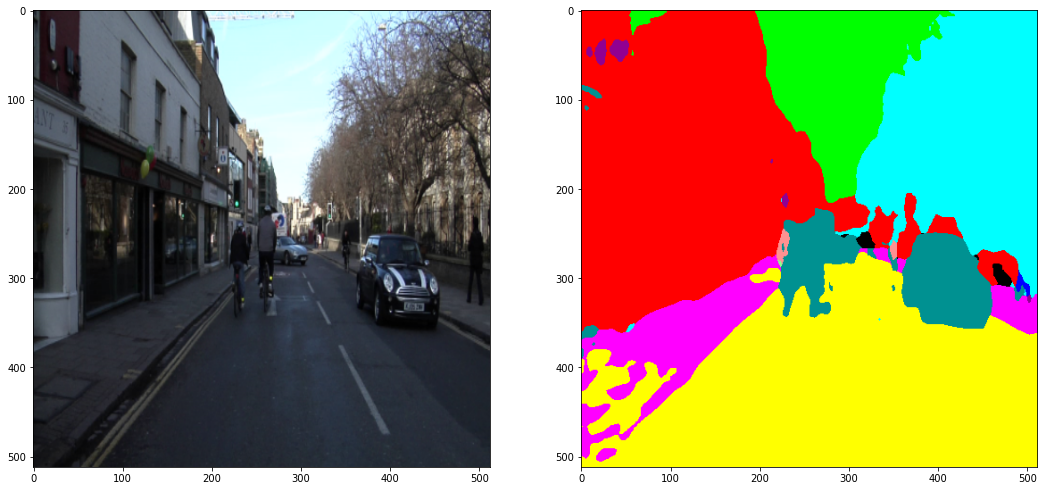

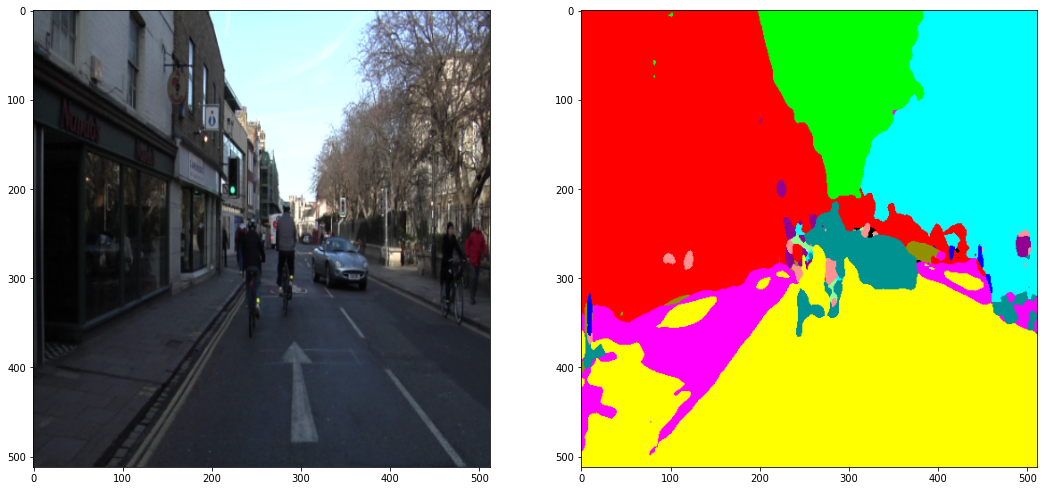

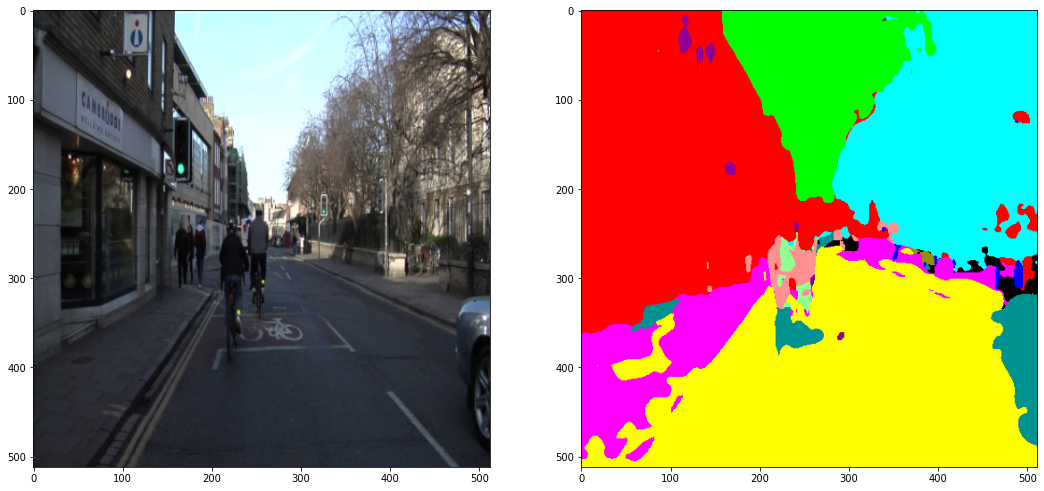

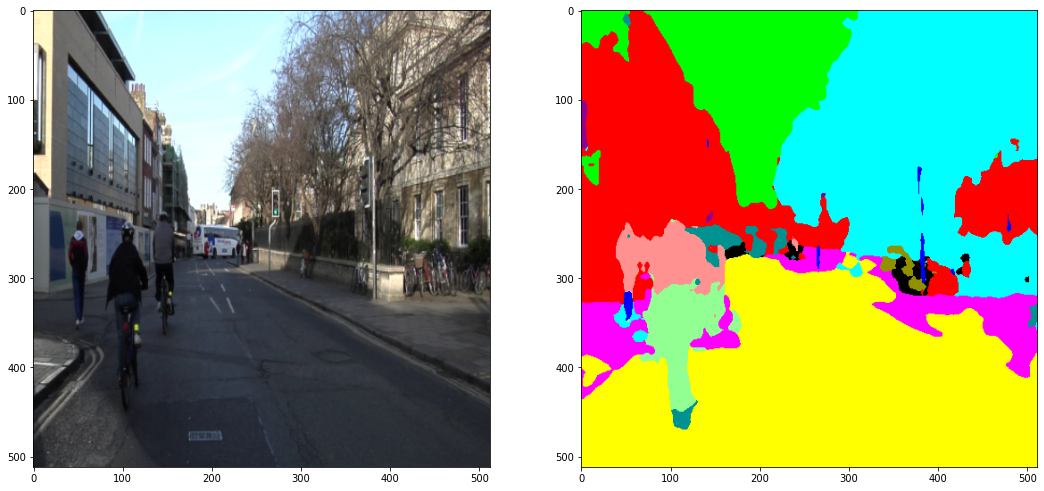

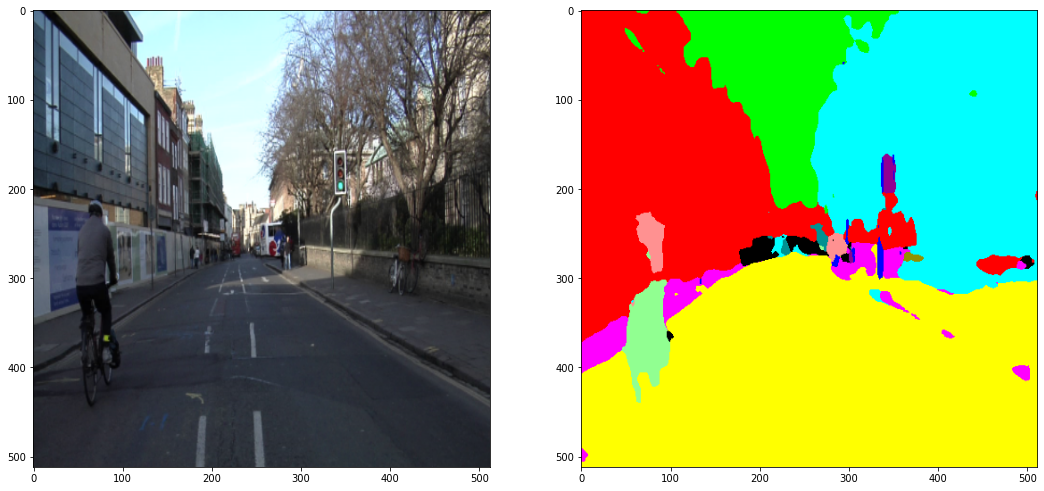

In [11]:
cm=np.array(colormap)
t_images=[test_images[0],test_images[25],test_images[50],test_images[75],test_images[100]]
plot_predictions(t_images, cm, model=model)

## Second Approach

We resized data to 512x512. Then we created our Dialated Spatial Pyramid Pooling by using VGG16 as backbone. 

### Modification of Dialated Spatial Pyramid Pooling with VGG16

Here is implementation of our first approach. We used moduler approach and create a conv_block and a DilatedSpatialPyramidPooling for generalization. We used **bilinear interpolation** in this approach.

We only used some of the layers of VGG as trainable so we have only 5,438,828 trainable parameters. This not only saves time but the use of SDPP gives improvement in accuracy and produces better results

In [5]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

In [6]:
def VGG16_DilatedSpatialPyramidPooling(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    vgg16 = keras.applications.VGG16(
        weights="imagenet", include_top=False, input_tensor=model_input
    )

    for layer in vgg16.layers:
      layer.trainable=False
    x = vgg16.get_layer("block5_pool").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = vgg16.get_layer("block3_conv3").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)


model = VGG16_DilatedSpatialPyramidPooling(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 512, 512, 64  36928       ['block1_conv1[0][0]']           
                             

### Compilation and Training

We used  

*   SparseCategoricalCrossentropy loss
*   Adam optimizer with learning rate 0.0001
* Accuracy as measure matrix
* 50 epochs for training
* 20% split for validation



In [36]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=loss,
    metrics=["accuracy"],
)

history = model.fit(train_dataset, validation_data=val_dataset, epochs=50)


Epoch 1/50
73/73 [==============================] - 33s 349ms/step - loss: 1.0968 - accuracy: 0.6658 - val_loss: 1.1764 - val_accuracy: 0.6952
Epoch 2/50
73/73 [==============================] - 25s 348ms/step - loss: 0.7696 - accuracy: 0.7633 - val_loss: 0.8508 - val_accuracy: 0.7710
Epoch 3/50
73/73 [==============================] - 23s 321ms/step - loss: 0.6290 - accuracy: 0.8054 - val_loss: 0.7426 - val_accuracy: 0.7903
Epoch 4/50
73/73 [==============================] - 26s 352ms/step - loss: 0.5318 - accuracy: 0.8358 - val_loss: 0.7016 - val_accuracy: 0.8025
Epoch 5/50
73/73 [==============================] - 26s 356ms/step - loss: 0.4638 - accuracy: 0.8571 - val_loss: 0.6843 - val_accuracy: 0.8094
Epoch 6/50
73/73 [==============================] - 26s 354ms/step - loss: 0.4160 - accuracy: 0.8713 - val_loss: 0.6852 - val_accuracy: 0.8122
Epoch 7/50
73/73 [==============================] - 26s 355ms/step - loss: 0.3807 - accuracy: 0.8816 - val_loss: 0.6885 - val_accuracy: 0.8132

### Test Accuracy

Test data has already been loaded. As mentioned earlier there are 101 data samples in test set.

This approach took much less time to train. It completed training in only 33% of total time compared to previouse approach. There is also significant improvement in accuracy. We have maximum accuracy of 89.71% by this approach.

In [44]:
preds = model.evaluate(test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

73/73 [==============================] - 12s 162ms/step - loss: 0.3114 - accuracy: 0.8972
Loss = 0.3113841116428375
Test Accuracy = 0.8971605896949768


### Training/Val accuracy/loss graph

Here is our traing and validation accuracy and loss graph

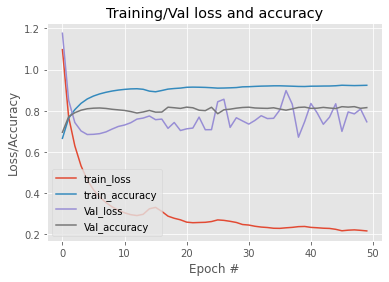

In [46]:
import matplotlib.pyplot as plt
N = np.arange(0, 50)
plt.style.use('ggplot')
plt.figure()
plt.plot(N, history.history['loss'], label='train_loss')
plt.plot(N, history.history['accuracy'], label='train_accuracy')
plt.plot(N, history.history['val_loss'], label='Val_loss')
plt.plot(N, history.history['val_accuracy'], label='Val_accuracy')
plt.title('Training/Val loss and accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

### Qualitative Results

We have shown few test samples to show how our model is perfoming. We created a custome colormap to show each class

In [8]:
# creating the Colormap
colormap = [[0,255,0],[255,0,0],[0,0,255],[255,255,0],[255,0,255],[0,255,255],[145,0,145],[145,145,0],[0,145,145],[255,145,145],[145,255,145],[145,145,255]]




def infer(model, image_tensor):
    predictions = model.predict(np.expand_dims((image_tensor), axis=0))
    predictions = np.squeeze(predictions)
    predictions = np.argmax(predictions, axis=2)
    return predictions


def decode_segmentation_masks(mask, colormap, n_classes):
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    for l in range(0, n_classes):
        idx = mask == l
        r[idx] = colormap[l, 0]
        g[idx] = colormap[l, 1]
        b[idx] = colormap[l, 2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb


def plot_samples_matplotlib(display_list, figsize=(5, 3)):
    _, axes = plt.subplots(nrows=1, ncols=len(display_list), figsize=figsize)
    for i in range(len(display_list)):
        if display_list[i].shape[-1] == 3:
            axes[i].imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        else:
            axes[i].imshow(display_list[i])
    plt.show()


def plot_predictions(images_list, colormap, model):
    for image_file in images_list:
        image_tensor = read_image(image_file)
        prediction_mask = infer(image_tensor=image_tensor, model=model)
        prediction_colormap = decode_segmentation_masks(prediction_mask, colormap, 11)
        plot_samples_matplotlib(
            [image_tensor, prediction_colormap], figsize=(18, 14)
        )

### Predicted samples

First image in each row is original image. Second is predicted color map

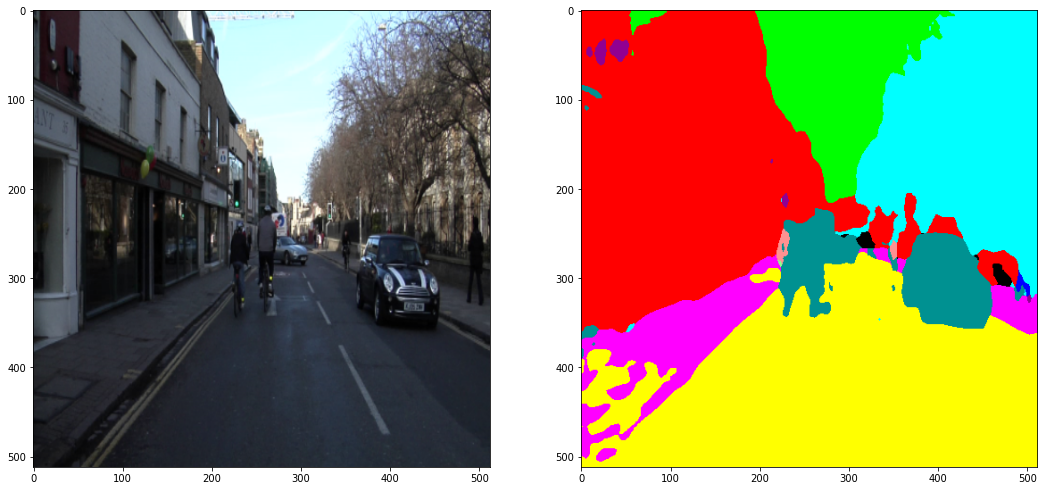

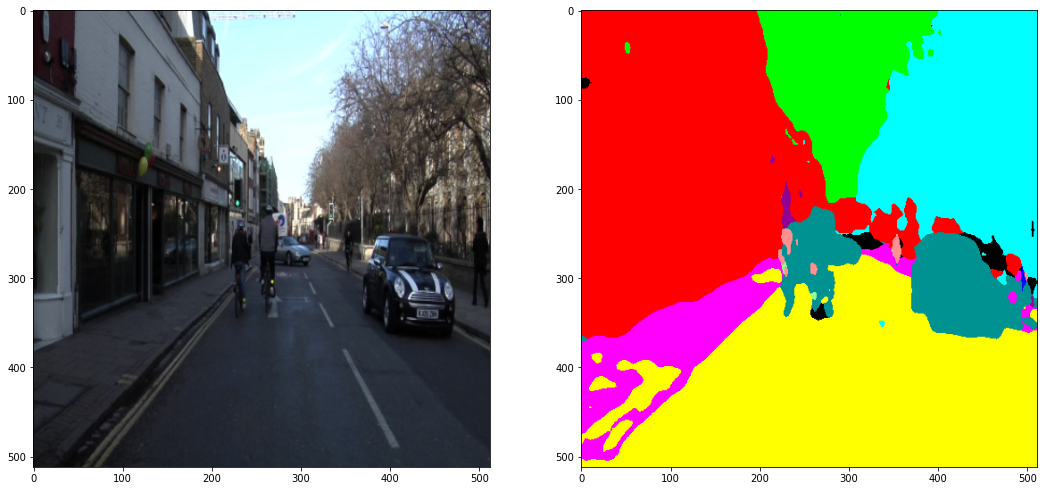

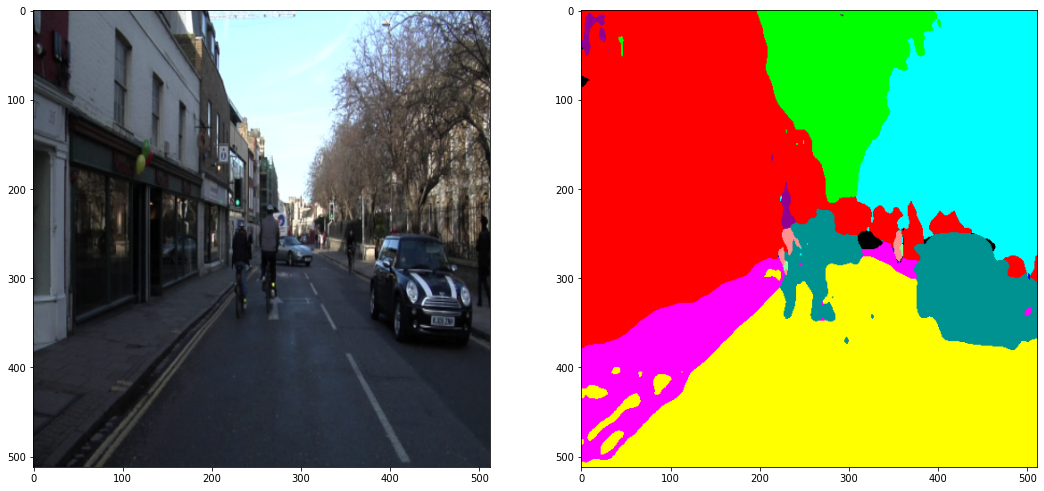

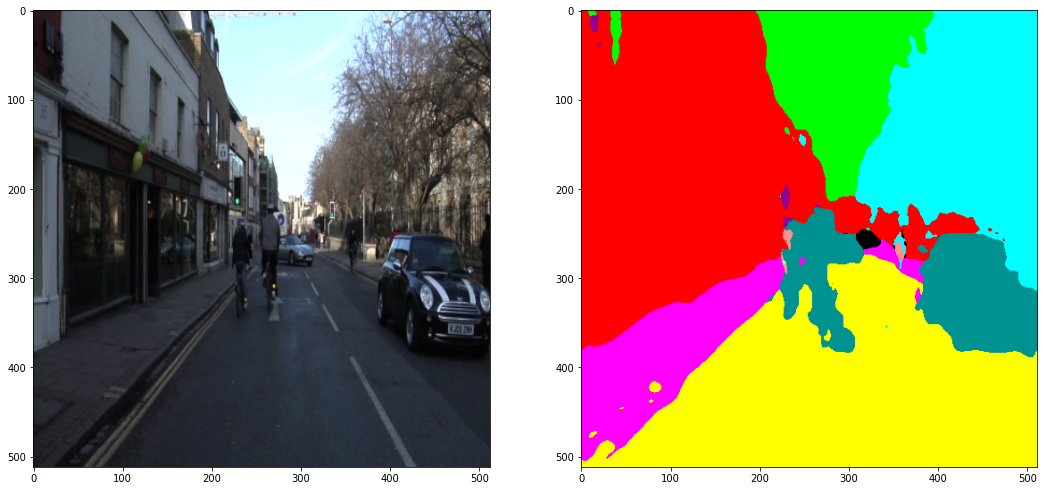

In [12]:
cm=np.array(colormap)
plot_predictions(test_images[:4], cm, model=model)